**A/B Testing**

In this notebook we will design, create and evaluate an A/B test: 


1. Design the Experiment 
2. Data Collection and ETL
3. EDA 
4. Hypothesis Testing
5. Analysis of Results

In [1]:
# Packages imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(16,6)})

# Design of Experiment

Analysis of subscription data for a service such as Medium that handles annual subscriptions of 200 and is paid in a single payment.

They have decided to redesign their website in order to get more conversions. The front-end UX/UI is ready to implement the new page layout. The goal of this redesign is to increase the number of conversions, which in this case is that users create an account.  

In addition, an exploratory analysis of the data has already been performed and you decided to first evaluate an aggregate effect without segmenting the groups.

## Hypothesis test design

Establishing the hypothesis test. Defining:  
$p_0:= \text{ the conversion probability of the original page.}$  
$p:=\text{ conversion probability of the redesigned page}$

### Null hypothesis

In this case the null hypothesis $H_0$ is that the new page design does not affect the number of conversions:  

> $H_0: \ \ \ \ \ \   p=p_0$

### Alternative Hypothesis

The redesign of the page affects the probability of conversion:  

> $H_1: \ \ \ \ \ \   p \neq p_0$ 
   
Note that the hypothesis is that it is different, it does not indicate whether it increased or decreased with the redesign. This means that we will use a [two-tailed test](https://en.wikipedia.org/wiki/One-_and_two-tailed_tests)  

### Significance level

In this case, we use a significance level of $5%$:  
> $ \alpha=.05$  

This means that our level of confidence is $95%$, since:  
> $(1- \alpha) = .95$

## Control Groups

In this case the **control** group will receive the old design, and the **treatment** group will receive the new design.

The front-end team must ensure that the page to be displayed to the user is **completely random**.

## Minimal Effect

Since the subscriptions offered are annual, and due to internal policies, the analysis must be performed on an annual basis. 

Metrics:
+ CPC = 5
+ Annual Maintenance Cost of users is $Co = 100$.
+ Annual CLTV after converting without costs is $V = 200$.
+ CLTV with costs is = $V - C_0 = (200-100)$ 
+ The actual conversion is .12 i.e. $p_0=.12$.

This implies that the expected **CLTV** per user who clicks on the ad is:  
+ $p_0 \times (V-Co) - CPC = .12 \times (200-100) - 5 = 7$  

Note that we are talking about the **Expected Value of the CLTV** not the **CLTV** as such, since we are not evaluating the effect of the redesign on user spending once they subscribe:
+ **CTVL** = 200 - 100. This remains fixed, as it is a metric defined by the company, and is conditional on the person having already subscribed. This definition **does not include acquisition costs, only maintenance and subscription costs**. 
+ The **expected CLTV** includes the acquisition costs, it is the **CLTV** of all our potential buyers, that's why we include the acquisition costs such as the CPC, and also the probability of subscribing $p \ \& \ p_0$.  
To avoid further confusion let us define the **expected CTVL** as $E$.


Where:  
+ $p_0 \times (V-Co)$  is the expected sale for any user who sees the ad, hence we multiply it by $p_0$. We only sell $V$ and pay $Co$ if the user converts.
+ CPC is the average cost per user that is redirected to the page, so you don't have to multiply it. On average the cost per click is 5, the probability of clicking is already implicit in the metric.

Let's plot how much our **E** changed given our new $p$ conversion, not including redesign costs:
+ Change in proportions is $\Delta_p = p-p_0$
+ Change in **E** without redesign costs: $\Delta_{E}=(p-p_0) \times (V-Co)$ 
>   $\Delta_{E} = (\Delta_p) \times (200-100) = \Delta_p*100 $  

The CPC remains constant and is not included in the equation, as the redesign is of the page, not of the way in which users arrive, so it does not affect the click-through rate.

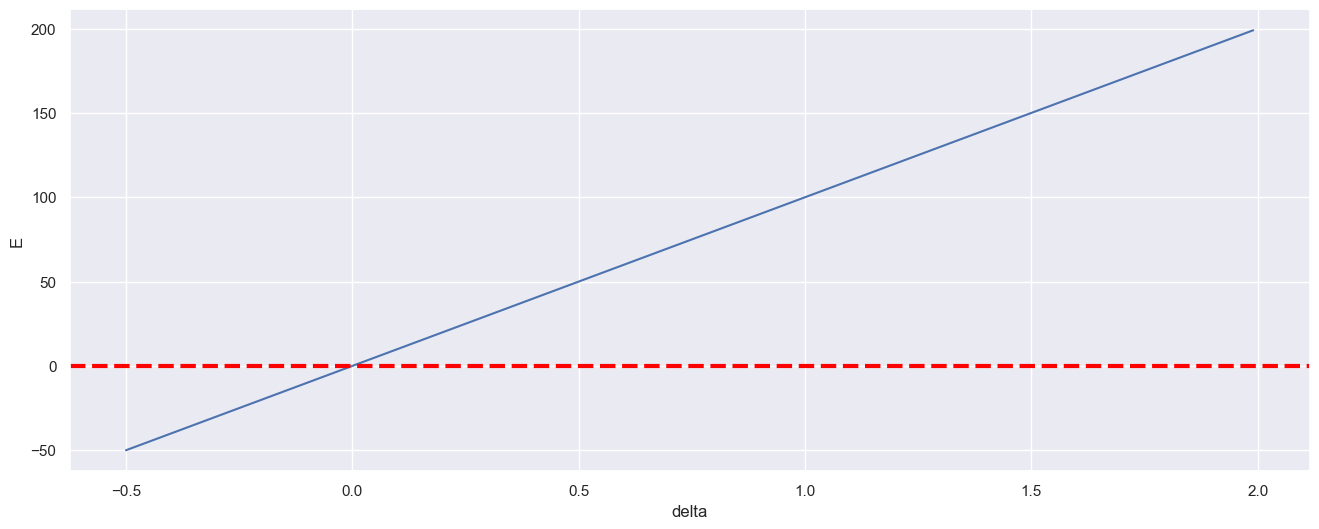

In [2]:
delta = pd.Series(list(range(-50,200,1)))/100 #delta_p
# E
cltv = 100*delta #delta_E

evaluacion = pd.DataFrame({'delta':delta, 'E':cltv})
sns.lineplot(data=evaluacion, x='delta', y='E')
plt.axhline(0, ls='--', linewidth=3, color='red')

Well since our model is linear, the behavior is linear. However this is the methodology to follow no matter if the model is not linear.

Now we will see how our monthly revenue would change. To do this we must include the number of users who actually view our page (regardless of whether they convert or not).
+ Let $m$ be the number of people who click and load our page.
$m$ is almost equivalent to the clicks we have, minus the people who leave before viewing the page and the users who enter more than us times. For now it is a good approximation.

From analyzing the above models it appears that on average **$m$ is 95 thousand** users per month. And since it is an A/B testing and the way of redirecting potential users to the site will not change, it is a good projection.

This means that since **the user is redirected to our page**:
+ The average number of users converting monthly is: $p_0 \times m$
+ The average number of users that will convert under the redesign is: $p \times m$
+ The change in the average number of users who convert:  $(p - p_0) \times m$

Now let's calculate how **Monthly Income** would change depending on $p$. This is nothing more than:  
+ Change in Monthly Income:  $\Delta_{ingreso}=\Delta_{E}*m = \Delta_p*100 \times m$  

Note: $E$ is not divided by twelve months, as the user pays the entire subscription in one installment.

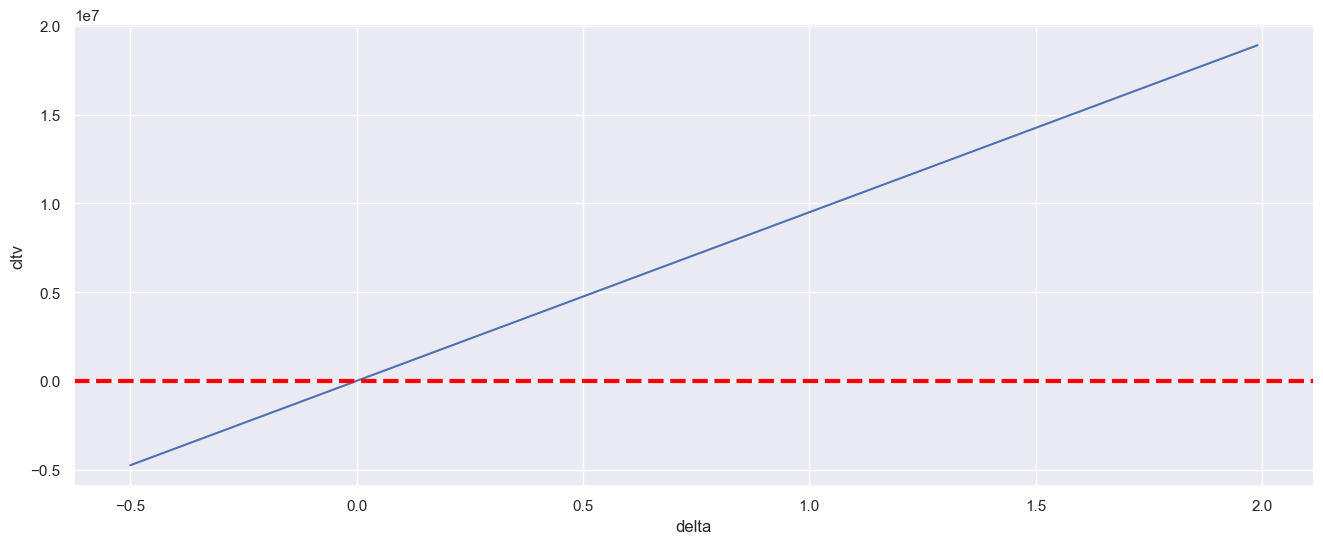

In [3]:
delta = pd.Series(list(range(-50,200,1)))/100
cltv = 100*delta*95000

evaluacion = pd.DataFrame({'delta':delta, 'cltv':cltv})
sns.lineplot(data=evaluacion, x='delta', y='cltv')
plt.axhline(0, ls='--', linewidth=3, color='red')

Let $R$ be the cost of the redesign, and of the necessary modifications to the infrastructure. That is, the cost of the project or campaign.

Now let's move on to something more interesting. Let's see how much $p$ it would have to be to **cover the cost of redesigning the site in one month**. This is equivalent to finding the point where the extra revenue generated by new users equals the redesign cost. Let's call this $p$ that covers the costs in one month $p_e$ or $p$ break-even such that:  

Mathematically it is equivalent to clearing $p$ from the following equation (we ignore the CPC as that variable will not be affected and is already averaged):  
+ $R = \Delta_E \times m $
+ $R = \Delta_p*(V - C_o) \times m $
+ $R = (p-p_0)*(V - C_o) \times m$  


We can also see the problem at the monthly level as:
+  The change of the expected income of our policy, **per user that enters the page**: 
> > > $\Delta_E = p(V - C_o) - p_0(V-C_o)$
+ The expected change of our policy, **for all users accessing the site**:  
> > > $m \times \Delta_E = m \times [p(V - C_o) - p_0(V-C_o)]$  

+ This change should cover at least the $R$ cost of implementation:
> > > $R \leq m \Delta_E$  

+ If we want to stay the same, we change " $\leq$ " by "$=$" and depearing.  
Any $p$ such that:  
> > > "$R < m \Delta_E =  (p - p_0)(V - C_o)m$" makes us money. And by the time it evens out we will have covered the implementation costs $R$. 


The clearing is:
> > > $p_e = \frac{R}{100 \times m} + p_0$  
Substituting with the information we know is as follows:  
> > > $p_e = \frac{R}{100 \times 95000} + .12$


Assuming that $R$ is 1.5 million, which would give us a $p_e$ of:
> > > $p_e \approx .277$

So any $p > p_e$ makes us money.

This implies an increase of $15.7$% in conversion. This may be very high, as from previous experience it is known that the changes are very small. But there is no problem, because given the company's future plans, they are willing to invest in the redesign if the cost is covered in one year. 

The math would be as follows:
+ The change of the expected income of our policy, **per user that enters the page**.:
> > > $\Delta_E = p(V - C_o) - p_0(V-C_o)$ 
+  The expected change of our policy, **for all users accessing the site**.: 
> > >$m \times \Delta_E = m \times [p(V - C_o) - p_0(V-C_o)]$
+ The change of the expected income of our policy, **for t months**. Remember that every month $m$ users enter the site.: 
> > > $t \times m \times \Delta_E = t \times m \times [p(V - C_o) - p_0(V-C_o)]$  
+ This change should cover at least the $R$ cost of implementation:
> > > $R \leq tm \Delta_E$  
+ If we want to be the same, we change "$\leq$" for "$=$" and clear.  
Any $p$ such that 
> > >"$R < tm \Delta_E =  (p - p_0)(V - C_o)tm$" makes us money. And, by the time it evens out we will have covered the implementation costs $R$.  


This would give us a new $p_e$ of: 
> > > $p_e = \frac{R}{100 \times m \times t} + p_0$   

Where $t$ is the maximum number of months in which the company is willing to cover the cost $R$.  
> > > $ p_e = \frac{R}{100 \times 95000 \times 12} + .12$  

> > > $ p_e \approx .133 $

The change we expect is $1.3$% Given that the result of similar changes in the past has brought an increase of plus or minus $3$% it seems a sensible idea.

Note that strictly speaking, we could leave $p_0$ as **unknown**. **We do not know $p_0$. Well, regardless of its value, we could calculate the necessary change. $\Delta_{p_e} = p_e - p_0$: 
> > > $ p_e - p_0 = \frac{R}{100 \times m \times t} $ 
     
> > > $ p_e - p_0 = \frac{R}{100 \times 95000 \times 12}$  
  
> > > $p_e - p_0 \approx .0133 $

## Sample Size

 Let's determine the power or potency of our analysis of our test. It depends on 3 factors:  
 > + [Statistical Power](https://es.wikipedia.org/wiki/Poder_estad%C3%ADstico) of our test:= This is defined as the probability of finding a statistically significant difference between the two groups, **given that the difference exists**. A value of $.8$ is generally used. 
 > + [Significance level](https://es.wikipedia.org/wiki/Significaci%C3%B3n_estad%C3%ADstica): It is the $\alpha$ that we previously decided and is defined as the probability of rejecting the null hypothesis given that it is true.  
 > + Effect: How big is the effect of our sample.

### Let's calculate the sample size

+ [sms.proportion_effectsize()](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_effectsize.html)
+ [sms.NormalIndPower()](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.NormalIndPower.html): We use a normal because we are calculating a difference of proportions.

In [4]:
# Calculating the effect size
efecto = sms.proportion_effectsize(0.12, 0.133) 
print(efecto)

# Let's calculate the minimum sample size needed
n_muestra = sms.NormalIndPower().solve_power(
    efecto, 
    power=0.8, 
    alpha=0.05 
    )                                                  

print(n_muestra)

-0.03912003793092855
10257.418429123258


Well our minimum sample size is **10258 individuals per group**.

Given that the $m$ is 95000 users on average, assigning a probability of $50$% to be control or treatment would result in more than needed.

### Experiment duration

Since there is no rush to evaluate the results, it is decided that the experiment will run for 3 months, so your sample size will be much larger than expected.

# ETL

The data are obtained from [Kaggle](https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv)

In [5]:
ab = pd.read_csv('https://raw.githubusercontent.com/IEXE-Tec/mcda-marketing/main/ab_data.csv')
ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [6]:
ab.shape

(294478, 5)

In [7]:
ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


# EDA

## Users

### Users in both groups

In [8]:
ab.groupby(['group'])['converted'].count()

group
control      147202
treatment    147276
Name: converted, dtype: int64

In [9]:
ab['user_id'].nunique()

290584

In [11]:
id_trat = ab[ab['group']=='treatment']['user_id']
id_control = ab[ab['group']!='treatment']['user_id']
print(f'Users with treatment: {id_trat.nunique()}')
print(f'Users in control: {id_control.nunique()}')

Users with treatment: 146284
Users in control: 146195


In [12]:
id_filtrado = id_trat[id_trat.isin(id_control)]
print(f'Users in both groups: {id_filtrado.nunique()}')

Users in both groups: 1895


In this case there are only 1895 users in the two groups. Let's get rid of them for the moment, although in the future it could be useful to evaluate the repeated effect of the page, but at the moment there are so few that it is not worth it.

In [13]:
ab = ab[~ab['user_id'].isin(id_filtrado)]

In [14]:
ab['user_id'].nunique()

288689

### Repeated users

In [15]:
usuarios_duplicados = ab.drop_duplicates('user_id').shape[0]
print(ab.shape)
print(usuarios_duplicados)
print(f"Difference {ab.shape[0] - usuarios_duplicados}")

(290688, 5)
288689
Difference 1999


In this case the difference is so small, and we have so much data that we can delete it or leave it.

In [16]:
sesiones = ab['user_id'].value_counts(ascending=False)
ids_repetidos = sesiones[sesiones > 1].index
ab = ab[~ab['user_id'].isin(ids_repetidos)]
print(ab.shape)

(286690, 5)


In [17]:
ids_repetidos

Int64Index([788245, 655340, 937185, 856332, 899061, 738999, 644135, 779906,
            900794, 634005,
            ...
            791592, 648354, 718068, 659019, 703229, 838889, 837102, 895945,
            883139, 860231],
           dtype='int64', length=1999)

In [18]:
ab.groupby(['group'])['converted'].count()

group
control      143293
treatment    143397
Name: converted, dtype: int64

Well, after cleaning the data we observed that we still have much more users than required, which is a good sign.

## EDA results

In [19]:
prob_conversion = ab.groupby('group')['converted']

# Std of the conversion 
std_p = lambda x: np.std(x, ddof=0)             
# Standard error
se_p = lambda x: stats.sem(x, ddof=0)       

prob_conversion = prob_conversion.agg([np.mean, std_p, se_p])
prob_conversion.columns = ['conversion_rate', 'std_deviation', 'std_error']

prob_conversion.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.001
treatment,0.119,0.323,0.001


Immediately we notice that the conversions are very similar, i.e. $p$ is very close to $p_0$.  
+ $p_0=.120$
+ $p=.119$

# Hypothesis test

In [20]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [21]:
# Let's calculate the users in each group
control = ab[ab['group'] == 'control']['converted']
tratamiento = ab[ab['group'] == 'treatment']['converted']
n_con = control.count()
n_trat = tratamiento.count()
successes = [control.sum(), tratamiento.sum()]
nobs = [n_con, n_trat]
nobs

[143293, 143397]

In [22]:
successes

[17220, 17025]

+ [proportions_ztest()](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html): Test of z proportions.
+ [proportion_confint()](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_confint.html): Calculating confidence intervals for our estimators $p$ and $p_0$.

In [23]:
# Proportions test
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'Confidence interval for p_0 at 95%.: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'Confidence interval for p at 95%: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.19
p-value: 0.232
Confidence interval for p_0 at 95%.: [0.118, 0.122]
Confidence interval for p at 95%: [0.117, 0.120]


# Conclusions

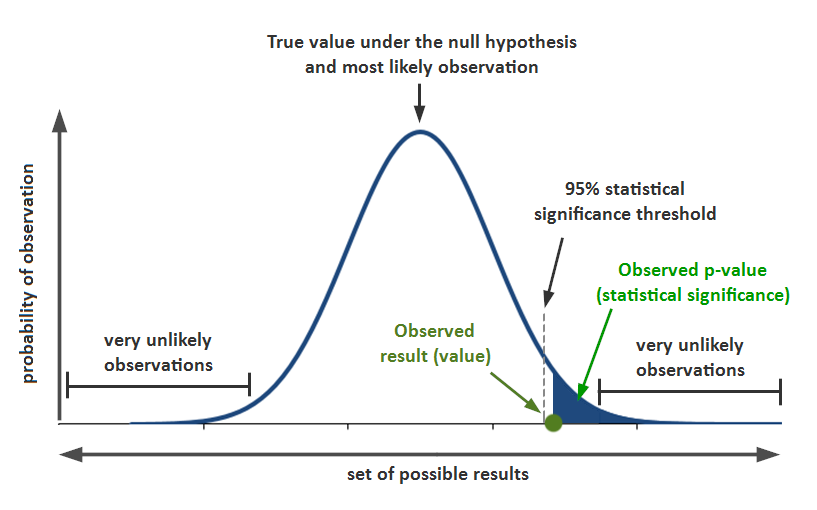

Since our **p-value** was a terrible $.232$ far short of our $.05$ we have no evidence to support rejecting $H_0$. Recall that $H_0$ is $p=p_0$ which means that the redesign probably had no effect.

Furthermore, looking at our confidence intervals at $95$% we can see that our desired effect of at least $15$% is not there:

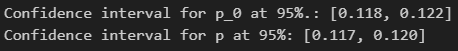

Moreover, even the effect of the new page seems to be negative at best! It's OK, these results sometimes happen...